## Introduction
Next steps: Conditional GAN to generate specific types of images rather than random ones like this GAN does.

## Import Libraries & Dependencies

Let's begin by installing the following dependencies.

In [1]:
# %pip install tensorflow tensorflow-datasets matplotlib ipywidgets

In [2]:
# %pip install tensorflow_datasets

In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

Use the `tensorflow_datasets` API to create a pipeline to the **training** split of the image dataset. Note that we're not *downloading* the entire dataset.

In [4]:
ds = tfds.load("fashion_mnist", split="train")

2023-08-29 12:58:52.927603: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 12:58:52.962724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-29 12:58:52.963783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 12:58:53.863051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Visualizing The Data

Create an **iterator** to return images from the dataset.

In [5]:
data_iterator = ds.as_numpy_iterator()

Visualize some images returned from the dataset by the iterator using `matplotlib`.

In [6]:
# Check image data structure shape
data_iterator.next()["image"].shape

(28, 28, 1)

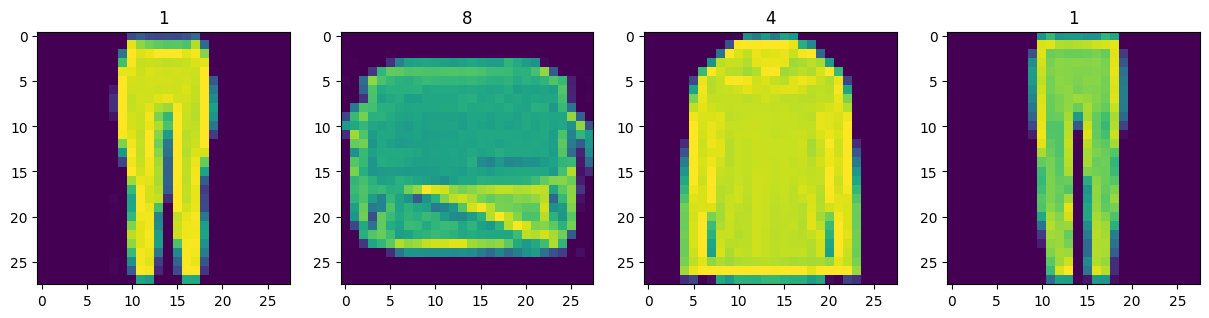

In [7]:
num_of_images = 4

(figure, subplots) =  plt.subplots(ncols=num_of_images, figsize=(15,15))

for subplot in subplots:
    # Get next image and label
    sample = data_iterator.next()
    
    # squeeze() changes image shape from (28,28,1) to (28,28)
    subplot.imshow(np.squeeze(sample["image"]))
    
    # Show each image's label above its visualization
    subplot.title.set_text(sample["label"])

## Building The Dataset

**Normalize** or apply **min-max scaling** to the images. Each attribute’s values are shifted and rescaled so that they end up between 0 and 1. Here, dividing each R, G, and B value by 255.

This is important because ML algorithms don’t perform well when the input numerical attributes have very different scales.


In [8]:
def scale_images(data):
    image = data["image"]
    return image / 255

ds = ds.map(scale_images)

**Cache** the data set to local storage to improve data loading performance.

Caching the dataset can be useful when working with large datasets that do not fit entirely in memory or when you want to avoid repeatedly loading data from a remote source, such as the internet.

By caching the dataset, subsequent accesses to the dataset will be faster since the data is already stored locally.

In [9]:
ds = ds.cache()

**Shuffle** the dataset.

In [10]:
ds = ds.shuffle(60000) # 60000 is the shuffle batch size

**Batch** the images into samples. 

In [11]:
images_per_sample = 128
ds = ds.batch(images_per_sample)

`prefetch()` is used to improve data loading performance by overlapping data loading and model execution. It prefetches a specified number of elements (usually batches) from the dataset.

In [12]:
ds = ds.prefetch(64)

Recreate the data iterator after these operations.

In [13]:
data_iterator = ds.as_numpy_iterator()
data_iterator.next().shape # Examine the new shape of next()'s return value

2023-08-29 12:58:55.602145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(128, 28, 28, 1)

## Building The Neural Networks

Import the model-building components.

In [14]:
from tensorflow.keras.models import Sequential  # One input, one output, flowing in one direction
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Dropout, LeakyReLU, UpSampling2D

Note about the **LeakyReLU** activation function:

[<img src="images/1_siH_yCvYJ9rqWSUYeDBiRA.png" width="500"/>](images/1_siH_yCvYJ9rqWSUYeDBiRA.png)

### Build The Generator

**Input Layer:** A dense, fully-connected layer. The generator is passed 128 random values (`input_dim`). These values determine what kind of image the generator will produce. The dimension 7\*7\*128 indicates a 7x7 array with 128 channels. 

**Activation:** The Leaky ReLU activation function provides the model **non-linearity**. 0.2 is the **output parameter** (0.01 in the image above).

**Reshape:** Takes in random values and reshapes it to 7x7x128.

**Upsampling Blocks:** Preserve the 128 channels of the input, specify a kernel size of 5x5, and set padding to **"same"** to prevent cropping.

`UpSampling2D()`**:** Duplicates the input dimensions (from 7x7x128 to 14x14x128)

In [15]:
def build_generator() -> Sequential:
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding="same"))
    model.add(LeakyReLU(0.2))


    # Convolutional block 1
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding="same"))
    model.add(LeakyReLU(0.2))

    # Final convolutional layer to reduce to a single channel
    model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))


    return model

Test the model.

In [16]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 145ms/step


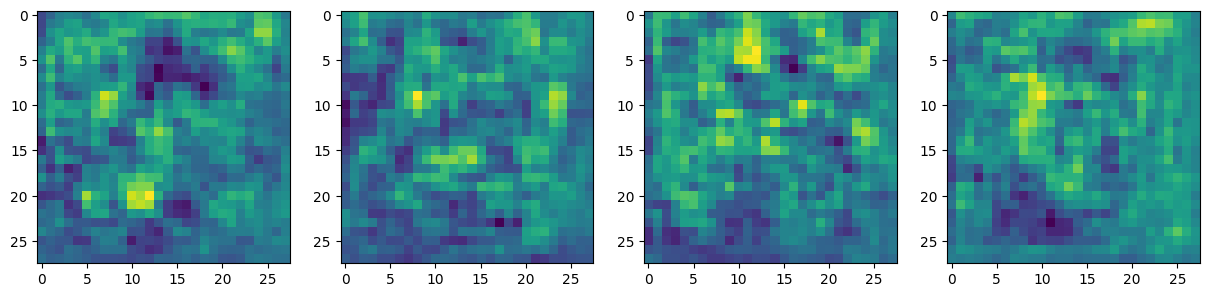

In [17]:
num_of_images = 4


img = generator.predict(np.random.randn(num_of_images,128,1))

(figure, subplots) =  plt.subplots(ncols=num_of_images, figsize=(15,15))

for i, img in enumerate(img):    
    # squeeze() changes image shape to (28,28)
    subplots[i].imshow(np.squeeze(img))

### Build The Discriminator

In [18]:
def build_discriminator():
    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, 5, input_shape=(28,28,1))) # 32 filters of shape 5x5, input shape the same as generator's output
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 2
    model.add(Conv2D(64, 5)) # 64 filters.Not the input layer, so no need to specify input shape
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional Block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())

    # Output Layer
    model.add(Dense(1, activation="sigmoid")) # Outputs a single value, 1 representing a false image, 0 true

    return model

In [19]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

Now let's test the discrimnator. The neural network a expects a batch of images, rather a than a single image.

In [20]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 39ms/step


(4, 28, 28, 1)

In [21]:
discriminator.predict(img)

1/1 [==============================] - 0s 91ms/step


array([[0.5002529 ],
       [0.50031424],
       [0.5003518 ],
       [0.50022155]], dtype=float32)

If we wanted to test a single image (say `img[1]`) with the discriminator network, we would have to expand its dimensions.

In [22]:
discriminator.predict(np.expand_dims(img[1], axis=0)) # axis along which the dimensions are expanded

1/1 [==============================] - 0s 18ms/step


array([[0.50031424]], dtype=float32)

## Building The Training Loop

This part of building a GAN can be quite difficult. A balance needs to be struck between the learning rates of the generator and the discriminator.

We need to ensure that the discriminator doesn't learn too fast, otherwise it would be able to detect a false image every time. Adding random noise to the output of the discriminator can help to slow it down.

Because GANs are essentially two different neural networks, we can't simply use the `fit()` method to train them simultaneously.

### Setup Loss Functions & Optimizers
Both the generator and the discriminator will use the same loss function (`binary_crossentropy`) and optimizer (`Adam`).

The generator will use the `binary_crossentropy` loss function even though it is producing images. Its output is passed to the discriminator which has a binary output, and the generator's reward is based on this output.

In [23]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

gen_optimizer = Adam(learning_rate=0.0001)
disc_optimizer = Adam(learning_rate=0.00001) # Discriminator must learn slower than the generator

### Build Subclassed Model
In TensorFlow, a **subclassed** model refers to creating a custom neural network model by subclassing the `tf.keras.Model` class. This lets us define the model architecture and behavior by writing code in a more object-oriented manner, giving us greater flexibility and control over the model's structure and functionality.

In [24]:
from tensorflow.keras.models import Model
from tensorflow import GradientTape, concat, zeros_like, ones_like, random, shape

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass arguments and keyword arguments to the base class
        super().__init__(*args, **kwargs)

        # Attributes for the generator and discriminator
        self.generator = generator
        self.discriminator = discriminator


    def compile(self, gen_loss, disc_loss, gen_optimizer, disc_optimizer, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Attributes for losses and optimizers
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer


    # train_step() is called instead of fit() 
    def train_step(self, batch):
        # Get data
        real_images = batch
        fake_images = self.generator(np.random.randn(128,128,1), training=False)  # Each batch/sample has 128 images
        
        # Train the discriminator
        with GradientTape() as d_tape:
            # Pass the obtained real & fake images to the discriminator
            yHat_real = self.discriminator(real_images, training=True) # Setting training=True causes the Dropout layers to activate
            yHat_fake = self.discriminator(fake_images, training=True)

            # Concatenate the predicted (yHat) values into a single large array
            yHat_realfake = concat([yHat_real, yHat_fake], axis=0)

            # This is a supervised learning problem, so we need to create labels (the actual values)
            y_realfake = concat([zeros_like(yHat_real), ones_like(yHat_fake)], axis=0)

            # Add random noise to slow down discriminator training
            noise_real = 0.15 * random.uniform(shape(yHat_real))   # Add random values to zeroes in y_realfake
            noise_fake = -0.15 * random.uniform(shape(yHat_fake))  # Subtract random values from ones in y_realfake
            noise_realfake = concat([noise_real, noise_fake], axis=0)
            y_realfake += noise_realfake

            # Calculate loss
            total_disc_loss = self.disc_loss(y_realfake, yHat_realfake)

            # Apply backpropagation:
            # 1. Calculate gradient for each of the trainable_variables
            disc_gradient = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)

            # 2. Apply gradients to the optimizer. zip() used to apply gradients with respect to trainable_variables
            self.disc_optimizer.apply_gradients(zip(disc_gradient, self.discriminator.trainable_variables))

        # Train the generator
        with GradientTape() as g_tape:
            # Generate new images
            gen_images = self.generator(np.random.randn(128,128,1), training=True) # 128 sets of 128 random floats

            # Create predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # The goal is to trick the discriminator into thinking the images are real.
            # So we make all the labels 0, corresponding to real images (1 corresponds to fake images).
            generators_labels = zeros_like(predicted_labels)


            # Calculate loss.
            total_gen_loss = self.gen_loss(generators_labels, predicted_labels)

            # Apply backpropagation
            # 1. Calculate gradient for each of the trainable_variables
            gen_gradient = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)

            # 2. Apply gradients to the optimizer. zip() used to apply gradients with respect to trainable_variables
            self.gen_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"discriminator_loss":total_disc_loss,
                "generator_loss": total_gen_loss}

In [25]:
# Create an instance of the subclassed model
fashGAN = FashionGAN(generator, discriminator)

# Compile the instance
fashGAN.compile(gen_loss, disc_loss, gen_optimizer, disc_optimizer)

### Build Callbacks (Optional)

The following `ModelMonitor` class allows us to save the images as they are generated.

In [26]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128): # latent_dim is the number of random values passed to the generator
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = np.random.randn(self.num_img, self.latent_dim, 1)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

During training, it is usually the case that the final model is not the best in terms of the desired metric. This can be problematic and lead to wasted compute time given the stochastic nature of these models. **Checkpointing** allows us to save the model at a given frequency as it trains. We won't be using the `tf.keras.callbacks.ModelCheckpoint` callback since we're using a subclassed model.

In [27]:
import os
from tensorflow.keras.callbacks import Callback

class SaveModel(Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(os.path.join('models', f"g_{epoch}.h5"))
        self.model.discriminator.save(os.path.join('models', f"d_{epoch}.h5"))

### Train Subclassed Model

In [28]:
# Recommended epochs=2000
history = fashGAN.fit(ds, epochs=200, callbacks=[ModelMonitor(), SaveModel()])  # callbacks optional

Epoch 1/200
  1/469 [..............................] - ETA: 1:31:18 - discriminator_loss: 0.6951 - generator_loss: 0.6931

## Reviewing Training Performance

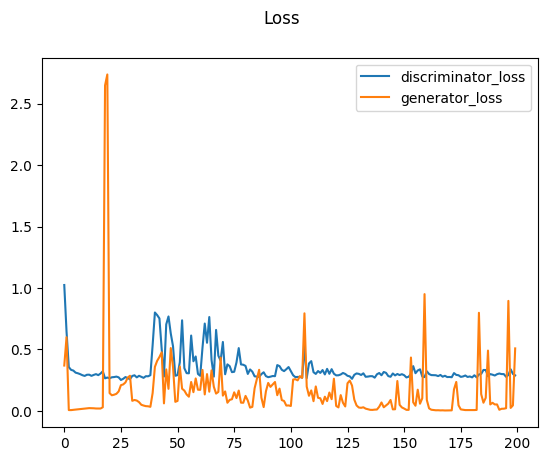

In [34]:
plt.suptitle("Loss")
plt.plot(history.history["discriminator_loss"], label="discriminator_loss")
plt.plot(history.history["generator_loss"], label="generator_loss")
plt.legend()
plt.show()

Save the generator and discriminator models.

In [39]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")

## Testing Out The Generator

1/1 [==============================] - 0s 18ms/step


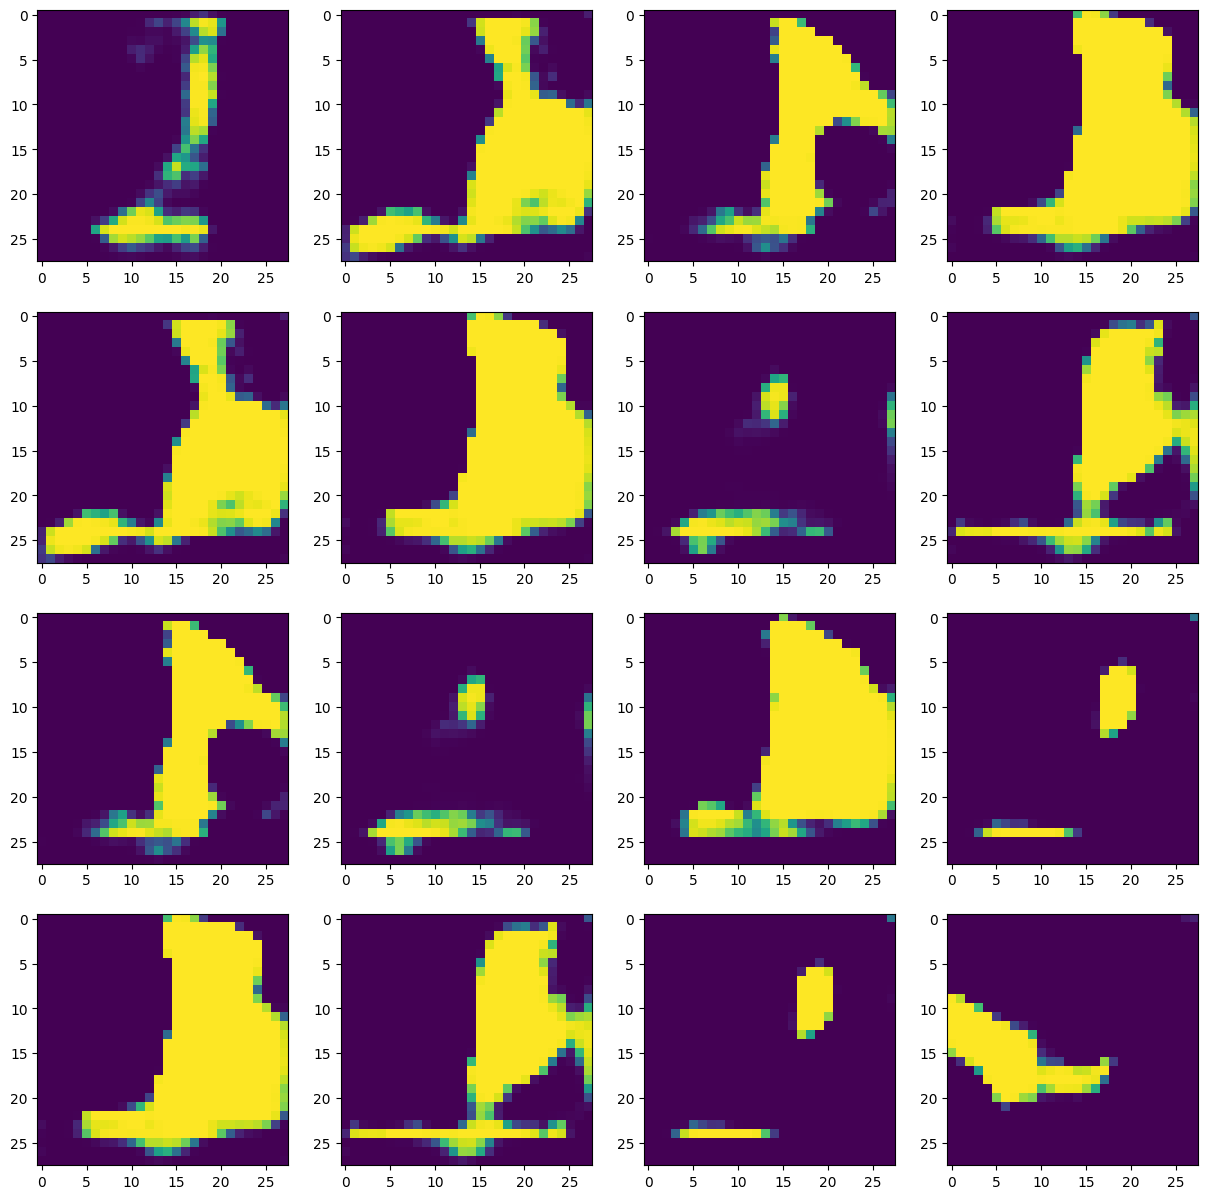

In [38]:
test_images = generator.predict(np.random.randn(16, 128, 1))

(figure, subplots) = plt.subplots(ncols=4, nrows=4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        subplots[i][j].imshow(test_images[(i+1) * (j+1) - 1])